In [1]:
import numpy as np
import pandas as pd

import random
import os

import string

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def save_torch_to_csv(torch_data,filename):
    pd.DataFrame(torch_data.detach().numpy()).to_csv(filename)

### Set random seeds

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print(f"seed: {seed}")
    
seed_everything(42)

seed: 42


In [4]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=2, stride=2),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

# 1 - Create a random(fixed) input

In [5]:
seed_everything(42)
batch_size     = 2
length_of_text = 7
my_input = torch.randint(0,20,[batch_size, length_of_text])
my_input

seed: 42


tensor([[ 2,  7, 16, 14,  6, 15,  0],
        [ 4, 10, 13, 18, 14, 10, 14]])

### Note that the input should be int, becasue the nn.Embedding layer accepts int inputs.

In [6]:
temp_input = torch.randn(batch_size, length_of_text)
temp_input

tensor([[ 0.3765, -0.1808,  0.3930,  0.4327, -1.3627,  1.3564,  0.6688],
        [-0.7077, -0.3267, -0.2788, -0.4220, -1.3323, -0.3639,  0.1513]])

In [7]:
temp_emb = nn.Embedding(num_embeddings = 20,
                        embedding_dim  = 5,
                        padding_idx    = 0)   
try:
    temp_emb(temp_input)
except Exception as e:
    print(e)

Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)


### Also, the range of input needs to be within 0 and n_tokens_in_vocabulary (defined below).

In [8]:
temp_input = torch.randint(0,100,[batch_size, length_of_text])
temp_input

tensor([[ 0, 83, 66, 80, 63, 47, 93],
        [28, 39, 78,  2, 25, 35, 24]])

In [9]:
temp_emb = nn.Embedding(num_embeddings = 20,
                        embedding_dim  = 5,
                        padding_idx    = 0)   
try:
    temp_emb(temp_input)
except Exception as e:
    print(e)

index out of range in self


### The output of the classifier with this input and pre-specified parameters

In [10]:
classifier = NewsClassifier(embedding_size = 5, 
                            num_embeddings = 20,
                            num_channels   = 3,
                            hidden_dim     = 5, 
                            num_classes    = 4, 
                            dropout_p      = 0,
                            pretrained_embeddings=None,
                            padding_idx    = 0)
print("Input")
print(f"The shape of input: {my_input.shape}")
print('-'*60)
print("Parameters")
for name, param in classifier.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")
print('-'*60)
print("Output")
print(f"The shape of output: {classifier(my_input).shape}")

Input
The shape of input: torch.Size([2, 7])
------------------------------------------------------------
Parameters
Parameter name: emb.weight, Shape: torch.Size([20, 5])
Parameter name: convnet.0.weight, Shape: torch.Size([3, 5, 3])
Parameter name: convnet.0.bias, Shape: torch.Size([3])
Parameter name: convnet.2.weight, Shape: torch.Size([3, 3, 2])
Parameter name: convnet.2.bias, Shape: torch.Size([3])
Parameter name: fc1.weight, Shape: torch.Size([5, 3])
Parameter name: fc1.bias, Shape: torch.Size([5])
Parameter name: fc2.weight, Shape: torch.Size([4, 5])
Parameter name: fc2.bias, Shape: torch.Size([4])
------------------------------------------------------------
Output
The shape of output: torch.Size([2, 4])


# 2 - nn.Embedding Layer

In [11]:
# the number of embeddings (the number of vocabulary items)
n_tokens_in_vocabulary = 20
# size of the embeddings (embedding dimension)
dimension_embedding    = 5
# If one specifies padding_idx=0 every input where the value is equal to padding_idx will 
# be zero-ed out 
padding_idx            = 0

# For example, 
# there are 6000 words in vocabulary, the pre-specified dimension is 50
# the size of embedding.weight will be [num_embeddings, embedding_dim] = [6000, 50]
# the length of the text is 6 (6 words in a sentence)
# the input of nn.Embedding(text): n_batch * 6. Let n_batch = 128 (considering 128 sentence).
# the output of nn.Embedding(text): 128 * 6 * 50. 
# After the nn.Embedding(), each vector (including 6 indeces) will be combined 
# with a function like sum() so the size will be 128 * 50

### Create a fixed Embedding 

In [12]:
seed_everything(42)
my_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary, 
                      embedding_dim  = dimension_embedding,
                      padding_idx    = padding_idx)  

seed: 42


### Shape of the embedding weights

In [13]:
temp_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary,
                        embedding_dim  = dimension_embedding,
                        padding_idx    = padding_idx)   
print(f"The size of Embedding weights: {temp_emb.weight.shape}")
print(f"The first dimension of weights equals num_embeddings.")
print(f"The second dimension of weights equals embedding_dim.")
print(temp_emb.weight)

The size of Embedding weights: torch.Size([20, 5])
The first dimension of weights equals num_embeddings.
The second dimension of weights equals embedding_dim.
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7048,  1.0131, -0.3308,  1.0950,  0.3399],
        [ 0.7200,  0.4114, -0.5733,  0.5069, -0.4752],
        [-0.4920, -0.1360,  1.6354,  0.6547,  0.5760],
        [-0.3609, -0.0606,  0.0733,  0.8187, -0.3753],
        [ 1.0331, -0.6867,  0.6368,  0.2176, -0.0467],
        [-1.4335, -0.5665,  0.2695, -0.2104, -0.7328],
        [ 0.1043,  1.0414, -0.3997, -2.2933,  0.4976],
        [-2.4801, -0.4175, -1.1955,  0.8123, -0.3063],
        [-0.3302, -0.9808,  0.1947,  0.2868, -0.7308],
        [ 0.1748, -1.0939,  0.9633, -0.3095,  0.5712],
        [ 1.1179, -1.5469,  0.7567,  0.7755,  2.0265],
        [ 0.9812, -0.6401, -0.4908,  0.2080, -0.9319],
        [-1.5910, -1.1360, -0.5226,  0.7165,  1.5335],
        [-1.4510, -0.7861,  1.0229, -0.5558,  0.7

### Using different padding_idx

In [14]:
### When using padding_idx > num_embeddings, an error will be reported
try:
    temp_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary,
                            embedding_dim  = dimension_embedding,
                            padding_idx    = 100)
except Exception as e:
    print(e)

Padding_idx must be within num_embeddings


In [15]:
temp_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary,
                        embedding_dim= dimension_embedding,
                        padding_idx    = 7)
print("With padding_idx=3, the fourth elements (index=3) in the weights will be all zeros.")
print("Meaning for all items=3 in the input, the outputs of those item will be 0.")
print("-"*100)
print(temp_emb.weight)
print("-"*100)
print(f"Embedding output for the first item:{my_input[0]}")
print(temp_emb(my_input)[0])
print("The second item in the output is [zeros], because the second item in the input is 7,")
print("and padding_idx=7.")
print("-"*100)
print(f"Embedding output for the first item:{my_input[1]}")
print(temp_emb(my_input)[1])

With padding_idx=3, the fourth elements (index=3) in the weights will be all zeros.
Meaning for all items=3 in the input, the outputs of those item will be 0.
----------------------------------------------------------------------------------------------------
Parameter containing:
tensor([[-4.6113e-01, -6.3885e-02, -1.3667e+00,  3.2982e-01, -9.8271e-01],
        [ 3.0177e-01,  1.7869e-01, -1.2931e-01, -1.5754e+00,  2.2508e+00],
        [ 1.0012e+00,  1.3642e+00,  6.3332e-01,  4.0500e-01,  3.4159e-01],
        [-2.2136e-01,  1.7290e-01,  1.0514e+00,  7.4915e-03, -7.7365e-02],
        [ 6.4269e-01,  5.7425e-01,  5.8672e-01, -1.8847e-02, -9.1432e-01],
        [ 1.4840e+00, -9.1091e-01, -5.2910e-01, -8.0515e-01,  5.1580e-01],
        [-7.1288e-01,  2.1962e-01,  5.6351e-01,  1.8582e+00,  1.0441e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4129e+00, -1.8791e+00, -1.7983e-01,  7.9039e-01,  5.2394e-01],
        [-2.6935e-01, -1.6191e+00,  1.2588e

### The embedding outputs

In [16]:
print("Input:")
print(my_input)
print('-'*100)
print("Weights:")
print(my_emb.weight)
print('-'*100)
print("Output:")
print(my_emb(my_input))

save_torch_to_csv(my_emb.weight,'embedding_weights.csv')
save_torch_to_csv(my_emb(my_input)[0],'embedding_results_0.csv')
save_torch_to_csv(my_emb(my_input)[1],'embedding_results_1.csv')

Input:
tensor([[ 2,  7, 16, 14,  6, 15,  0],
        [ 4, 10, 13, 18, 14, 10, 14]])
----------------------------------------------------------------------------------------------------
Weights:
Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00],
        [-3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01],
        [ 7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01],
        [-7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00],
        [ 1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02],
        [-2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01],
        [ 1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01],
        [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00],
        [ 2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01],
        [ 7.8024e-02,  5.2581e-01,

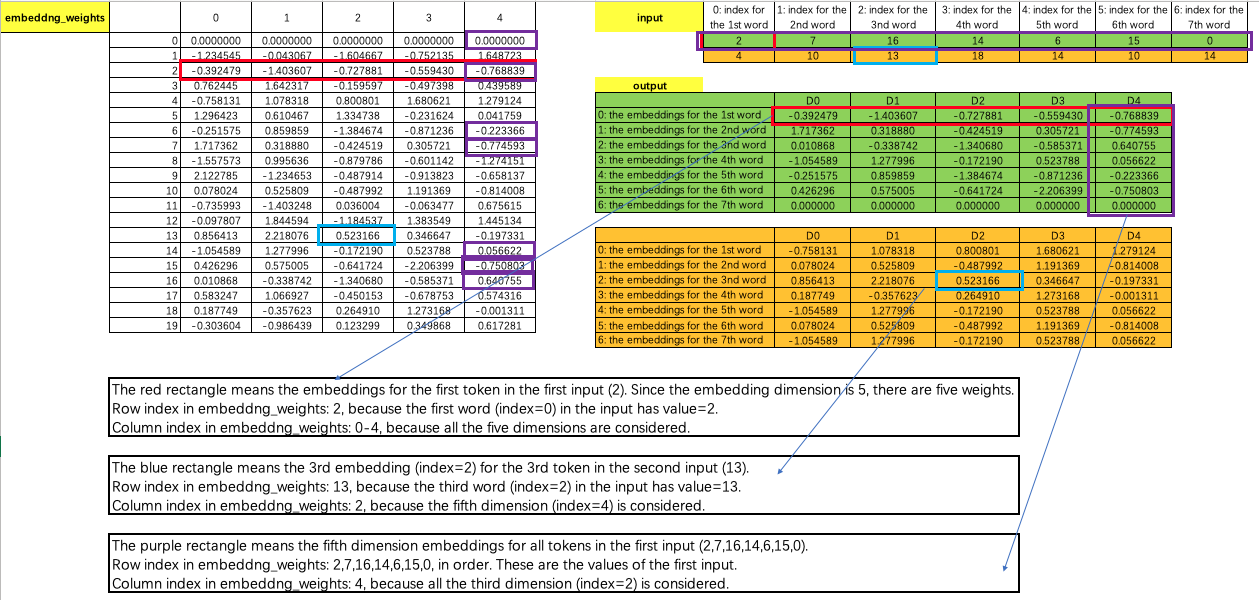

### The shape of the nn.Embedding layer is (batch_size, sequence_length, embedding_dim). The input of the nn.Conv1d layer should be (batch_size, in_channels, sequence_length). So the [torch.permute()](https://pytorch.org/docs/stable/generated/torch.permute.html) is used to rearrange the dimensions of the tensor so that the output shape conforms to the input format of the convolutional layer, thereby allowing the convolutional operation to be applied correctly.
### In the .permute(0,2,1) function, (0,2,1) is the desired ordering of dimensions.

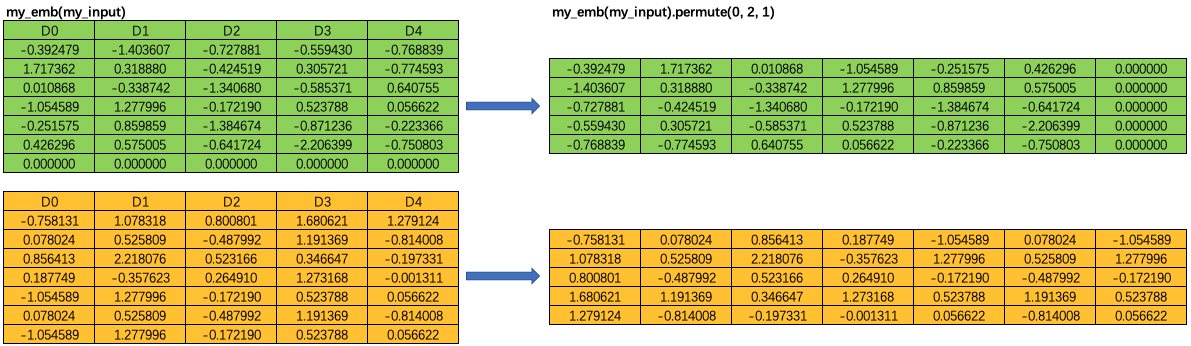

In [17]:
my_emb(my_input).shape

torch.Size([2, 7, 5])

In [18]:
my_emb(my_input).permute(0, 2, 1).shape

torch.Size([2, 5, 7])

# 3 - Convolution (CNN) Layers

In [19]:
seed_everything(1001)
conv1 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=2, stride=1)
seed_everything(1002)
conv2 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1)

seed: 1001
seed: 1002


### conv1

In [20]:
conv1.weight

Parameter containing:
tensor([[[-0.0661, -0.2154],
         [ 0.2253, -0.2131],
         [-0.1952, -0.1346],
         [-0.1812,  0.0941],
         [ 0.2638, -0.1884]],

        [[-0.2402, -0.0179],
         [-0.1150,  0.0836],
         [-0.2214, -0.0230],
         [-0.2773,  0.1791],
         [ 0.0614, -0.2922]]], requires_grad=True)

In [21]:
conv1.weight.shape

torch.Size([2, 5, 2])

In [22]:
conv1.bias

Parameter containing:
tensor([ 0.0084, -0.2075], requires_grad=True)

In [23]:
result_1 = conv1(my_emb(my_input).permute(0, 2, 1))
result_1

tensor([[[-0.4474, -0.1356,  0.4849,  0.3373,  0.3938,  0.4368],
         [ 0.6041, -0.9847,  0.5342, -0.1873,  0.1679,  0.3317]],

        [[ 0.3804, -0.8714,  0.3548, -0.3506,  0.5221, -0.1969],
         [-0.2092, -0.2812, -0.7033, -0.4163,  0.3002, -0.3521]]],
       grad_fn=<ConvolutionBackward0>)

In [24]:
result_1.shape

torch.Size([2, 2, 6])

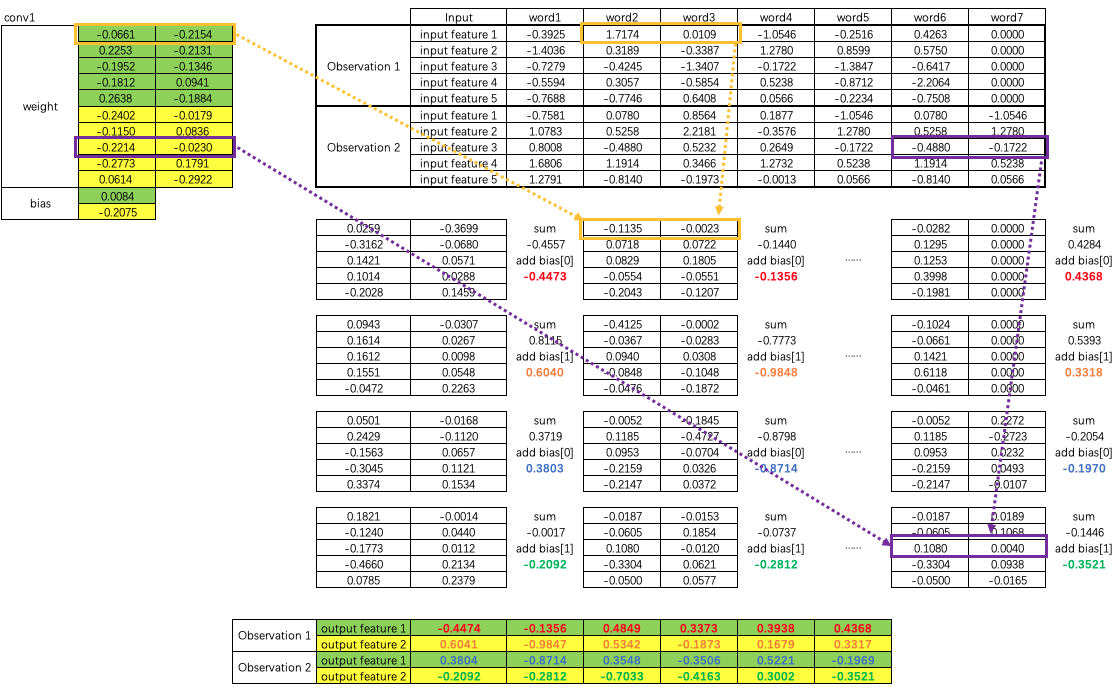

### conv2

In [25]:
conv2.weight

Parameter containing:
tensor([[[-0.4790,  0.4579],
         [-0.4440,  0.0293]],

        [[ 0.0354, -0.1297],
         [-0.2026, -0.4753]]], requires_grad=True)

In [26]:
conv2.weight.shape

torch.Size([2, 2, 2])

In [27]:
conv2.bias

Parameter containing:
tensor([ 0.3654, -0.1941], requires_grad=True)

In [28]:
result_2 = conv2(result_1)
result_2

tensor([[[ 0.2205,  1.1053,  0.0449,  0.4723,  0.3120],
         [ 0.1533, -0.3162, -0.2399, -0.2751, -0.4285]],

        [[-0.1312,  1.0494,  0.3350,  0.9661, -0.1184],
         [ 0.1083,  0.1203,  0.2043, -0.3326, -0.0436]]],
       grad_fn=<ConvolutionBackward0>)

In [29]:
result_2.shape

torch.Size([2, 2, 5])

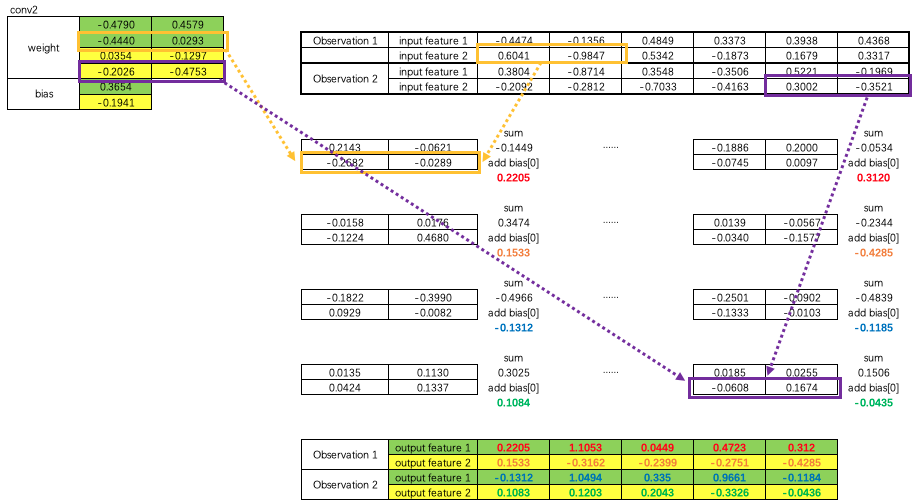

In [30]:
print("Input:")
print(f"shape: {my_input.shape}")
print('-'*100)
print("nn.Embedding(num_embeddings = 20, embedding_dim = 5, padding_idx = 0)")
print(f"shape: {my_emb(my_input).shape}")
print('-'*100)
print("permute(0,2,1)")
print(f"shape: {my_emb(my_input).permute(0, 2, 1).shape}")
print('-'*100)
print("conv1 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=2, stride=1)")
print(f"shape: {result_1.shape}")
print('-'*100)
print("conv2 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1)")
print(f"shape: {result_2.shape}")
print('-'*100)

Input:
shape: torch.Size([2, 7])
----------------------------------------------------------------------------------------------------
nn.Embedding(num_embeddings = 20, embedding_dim = 5, padding_idx = 0)
shape: torch.Size([2, 7, 5])
----------------------------------------------------------------------------------------------------
permute(0,2,1)
shape: torch.Size([2, 5, 7])
----------------------------------------------------------------------------------------------------
conv1 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=2, stride=1)
shape: torch.Size([2, 2, 6])
----------------------------------------------------------------------------------------------------
conv2 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1)
shape: torch.Size([2, 2, 5])
----------------------------------------------------------------------------------------------------


# 4 - nn.Linear Layers

In [31]:
print("The output of CNN layers:")
print(result_2)
print(f"Shape: {result_2.shape}")

The output of CNN layers:
tensor([[[ 0.2205,  1.1053,  0.0449,  0.4723,  0.3120],
         [ 0.1533, -0.3162, -0.2399, -0.2751, -0.4285]],

        [[-0.1312,  1.0494,  0.3350,  0.9661, -0.1184],
         [ 0.1083,  0.1203,  0.2043, -0.3326, -0.0436]]],
       grad_fn=<ConvolutionBackward0>)
Shape: torch.Size([2, 2, 5])


### Applies a 1D average [torch.nn.functional.avg_pool1d](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool1d.html)

In [32]:
remaining_size = result_2.size(dim=2)
remaining_size

5

In [33]:
avg_feature = F.avg_pool1d(input=result_2, kernel_size=remaining_size)
print(f"Shape: {avg_feature.shape}")
avg_feature

Shape: torch.Size([2, 2, 1])


tensor([[[ 0.4310],
         [-0.2213]],

        [[ 0.4202],
         [ 0.0113]]], grad_fn=<SqueezeBackward1>)

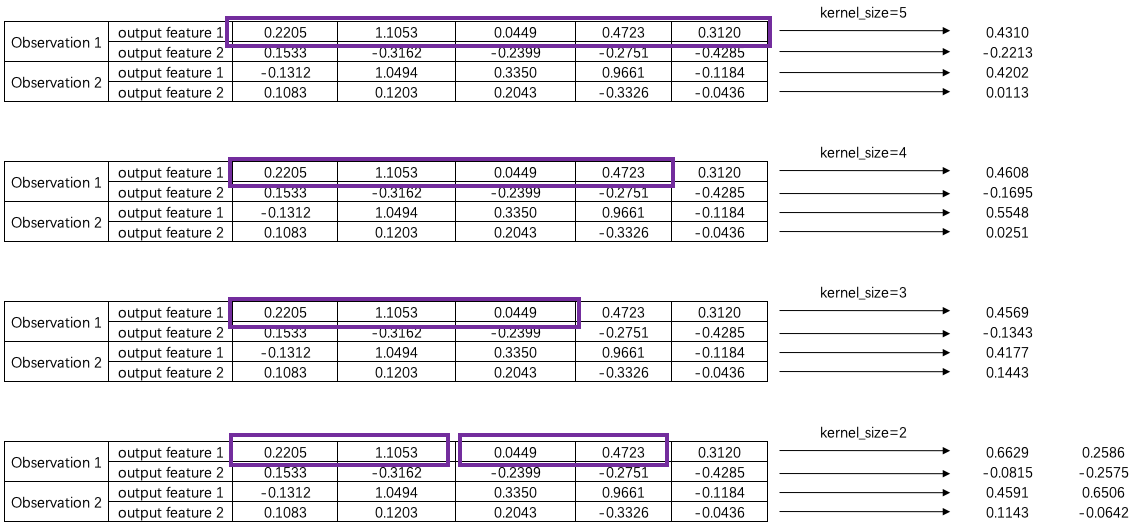

In [34]:
print(F.avg_pool1d(result_2, remaining_size))
print("-"*60)
print("Shape:")
print(F.avg_pool1d(result_2, remaining_size).shape)

tensor([[[ 0.4310],
         [-0.2213]],

        [[ 0.4202],
         [ 0.0113]]], grad_fn=<SqueezeBackward1>)
------------------------------------------------------------
Shape:
torch.Size([2, 2, 1])


### Returns a tensor with all specified dimensions of input of size 1 removed. [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html)
#### If the third dimension of x (i.e., the dimension with index 2) is not 1, then x.squeeze(dim=2) will not change the shape of the tensor. Specifically, .squeeze(dim=2) will only remove the dimension if its size is 1; if the size of that dimension is not 1, the operation will have no effect.

In [35]:
print(F.avg_pool1d(result_2, remaining_size).squeeze(dim=2))
print("-"*60)
print("Shape:")
print(F.avg_pool1d(result_2, remaining_size).squeeze(dim=2).shape)

tensor([[ 0.4310, -0.2213],
        [ 0.4202,  0.0113]], grad_fn=<SqueezeBackward1>)
------------------------------------------------------------
Shape:
torch.Size([2, 2])


In [36]:
seed_everything(1001)
fc1 = nn.Linear(2, 6)
seed_everything(1002)
fc2 = nn.Linear(6, 4)

seed: 1001
seed: 1002


### Input to the nn.Linear layers (output of the CNN layers)

In [37]:
linear_input = F.avg_pool1d(result_2, remaining_size).squeeze(dim=2)
linear_input

tensor([[ 0.4310, -0.2213],
        [ 0.4202,  0.0113]], grad_fn=<SqueezeBackward1>)

### Intermediate_vector (output of fc1)

In [38]:
fc1.weight

Parameter containing:
tensor([[-0.1479, -0.4817],
        [ 0.5038, -0.4764],
        [-0.4365, -0.3011],
        [-0.4052,  0.2104],
        [ 0.5898, -0.4212],
        [-0.5372, -0.0399]], requires_grad=True)

In [39]:
fc1.weight.shape

torch.Size([6, 2])

In [40]:
fc1.bias

Parameter containing:
tensor([-0.2572,  0.1869, -0.4950, -0.0515, -0.6200,  0.4005],
       requires_grad=True)

In [41]:
intermediate_vector = fc1(linear_input)
intermediate_vector

tensor([[-0.2143,  0.5095, -0.6165, -0.2727, -0.2726,  0.1778],
        [-0.3248,  0.3932, -0.6818, -0.2194, -0.3769,  0.1743]],
       grad_fn=<AddmmBackward0>)

In [42]:
intermediate_vector.shape

torch.Size([2, 6])

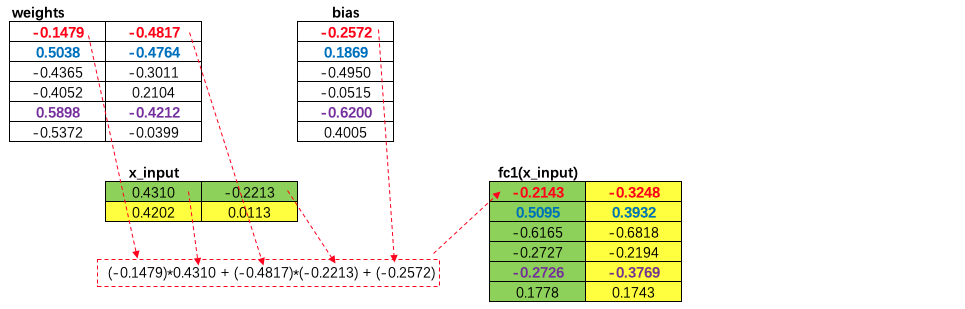

### Prediction_vector (output of fc2)

In [43]:
fc2.weight

Parameter containing:
tensor([[-0.3911,  0.3739, -0.3625,  0.0240,  0.0289, -0.1059],
        [-0.1654, -0.3881,  0.2984, -0.1585,  0.3965, -0.3312],
        [-0.1415,  0.1242, -0.3313, -0.2050,  0.0192, -0.3876],
        [-0.1108,  0.2151,  0.1621,  0.2935, -0.1502, -0.0877]],
       requires_grad=True)

In [44]:
fc2.weight.shape

torch.Size([4, 6])

In [45]:
fc2.bias

Parameter containing:
tensor([-0.3039,  0.1222, -0.1849, -0.3573], requires_grad=True)

In [46]:
prediction_vector = fc2(intermediate_vector)
prediction_vector

tensor([[ 0.1606, -0.3478,  0.0947, -0.3786],
        [ 0.1827, -0.3525,  0.1059, -0.3703]], grad_fn=<AddmmBackward0>)

In [47]:
prediction_vector.shape

torch.Size([2, 4])

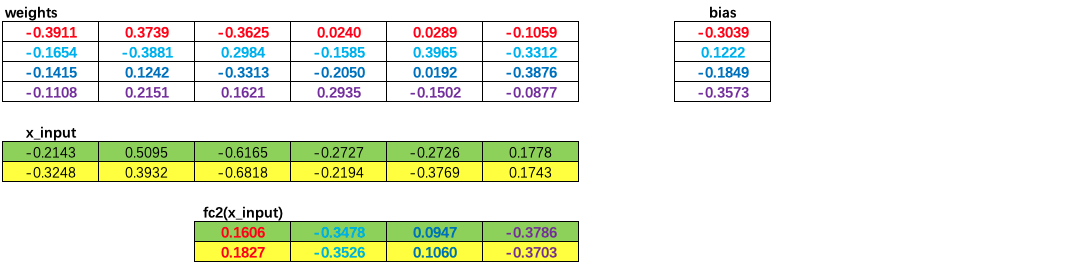

In [48]:
print("Output of CNN layers:")
print(f"shape: {result_2.shape}")
print('-'*100)
print("F.avg_pool1d")
print(f"shape: {F.avg_pool1d(result_2, 5).shape}")
print('-'*100)
print("squeeze(dim=2) - input of the nn.Linear layers")
print(f"shape: {F.avg_pool1d(result_2, 5).squeeze(dim=2).shape}")
print('-'*100)
print("fc1 = nn.Linear(2, 6)")
print(f"shape: {fc1(linear_input).shape}")
print('-'*100)
print("fc1 = nn.Linear(6, 4)")
print(f"shape: {fc2(fc1(linear_input)).shape}")
print('-'*100)

Output of CNN layers:
shape: torch.Size([2, 2, 5])
----------------------------------------------------------------------------------------------------
F.avg_pool1d
shape: torch.Size([2, 2, 1])
----------------------------------------------------------------------------------------------------
squeeze(dim=2) - input of the nn.Linear layers
shape: torch.Size([2, 2])
----------------------------------------------------------------------------------------------------
fc1 = nn.Linear(2, 6)
shape: torch.Size([2, 6])
----------------------------------------------------------------------------------------------------
fc1 = nn.Linear(6, 4)
shape: torch.Size([2, 4])
----------------------------------------------------------------------------------------------------
